In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import joblib
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from sklearn.metrics import r2_score

save_path = "../models/"

In [3]:
X_train = pd.read_csv("../datasets/inputs/train/X_train_norm.csv")
y_train = pd.read_csv("../datasets/inputs/train/y_train_norm.csv")
X_val = pd.read_csv("../datasets/inputs/val/X_val_norm.csv")
y_val = pd.read_csv("../datasets/inputs/val/y_val_norm.csv")
X_test = pd.read_csv("../datasets/inputs/test/X_test_norm.csv")
y_test = pd.read_csv("../datasets/inputs/test/y_test_norm.csv")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.FloatTensor(X_train.astype(float).values).to(device)
y_train_tensor = torch.FloatTensor(y_train.astype(float).values).to(device)
X_val_tensor = torch.FloatTensor(X_val.astype(float).values).to(device)
y_val_tensor = torch.FloatTensor(y_val.astype(float).values).to(device)
X_test_tensor = torch.FloatTensor(X_test.astype(float).values).to(device)
y_test_tensor = torch.FloatTensor(y_test.astype(float).values).to(device)

train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=2048)
test_loader = data.DataLoader(test_dataset, batch_size=2048)

Using device: cuda


## NN


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(
        self,
        max_width=512,
        lr=0.0001,
        dropout_rate=0.3,
        weight_decay=1e-4,
    ):
        super(NeuralNetwork, self).__init__()
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

        self.input = nn.Linear(326, max_width)
        self.bn1 = nn.BatchNorm1d(max_width)
        self.fc1 = nn.Linear(max_width, max_width // 2)
        self.bn2 = nn.BatchNorm1d(max_width // 2)
        self.fc2 = nn.Linear(max_width // 2, max_width // 4)
        self.bn3 = nn.BatchNorm1d(max_width // 4)
        self.output = nn.Linear(max_width // 4, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()
        self.losses = {"train": [], "val": []}
        self.to(device)

        # Early stopping parameters
        self.best_val_loss = float("inf")
        self.counter = 0
        self.best_model_state = None

    def forward(self, x):
        x = self.input(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.output(x)
        return x

    def train_step(self, x, y):
        predictions = self(x)
        loss = self.criterion(predictions, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def fit(
        self,
        train_loader,
        val_loader,
        epochs=10,
        patience=10,
        min_delta=0.0,
    ):
        for _ in tqdm(range(epochs), desc="Training", unit="epoch"):
            total_loss = 0
            num_batches = 0
            for x_batch, y_batch in train_loader:
                loss = self.train_step(x_batch, y_batch)
                total_loss += loss
                num_batches += 1
            self.losses["train"].append(total_loss / num_batches)

            # Early stopping
            val_loss = self.evaluate(val_loader)
            if val_loss < self.best_val_loss - min_delta:
                self.best_val_loss = val_loss
                self.counter = 0
                self.best_model_state = self.state_dict().copy()
            else:
                self.counter += 1
                if self.counter >= patience:
                    self.load_state_dict(self.best_model_state)
                    break

        return self.losses

    def evaluate(self, val_loader):
        self.eval()
        total_val_loss = 0
        num_batches = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                predictions = self(x_batch)
                loss = self.criterion(predictions, y_batch)
                total_val_loss += loss.item()
                num_batches += 1
        avg_val_loss = total_val_loss / num_batches
        self.losses["val"].append(avg_val_loss)
        return avg_val_loss

    def predict(self, dataloader):
        self.eval()
        predictions = []
        with torch.no_grad():
            for x_batch, _ in dataloader:
                batch_predictions = self(x_batch)
                predictions.append(batch_predictions)
        return torch.cat(predictions, dim=0)

    def test(self, test_loader):
        X_test, y_test = test_loader.dataset[:][0], test_loader.dataset[:][1]
        self.eval()
        with torch.no_grad():
            predictions = self(X_test)
            r2 = r2_score(y_test.cpu().numpy(), predictions.cpu().numpy())
            mse = F.mse_loss(predictions, y_test).item()
        return r2, mse

    def save(self, name):
        joblib.dump(self.state_dict(), save_path + name)

    def load(self, name):
        self.load_state_dict(joblib.load(save_path + name))

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses["train"], label="Training Loss")
        plt.plot(self.losses["val"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Losses")
        plt.legend()
        plt.grid(True)
        plt.show()

Training: 100%|██████████| 20/20 [05:48<00:00, 17.45s/epoch]


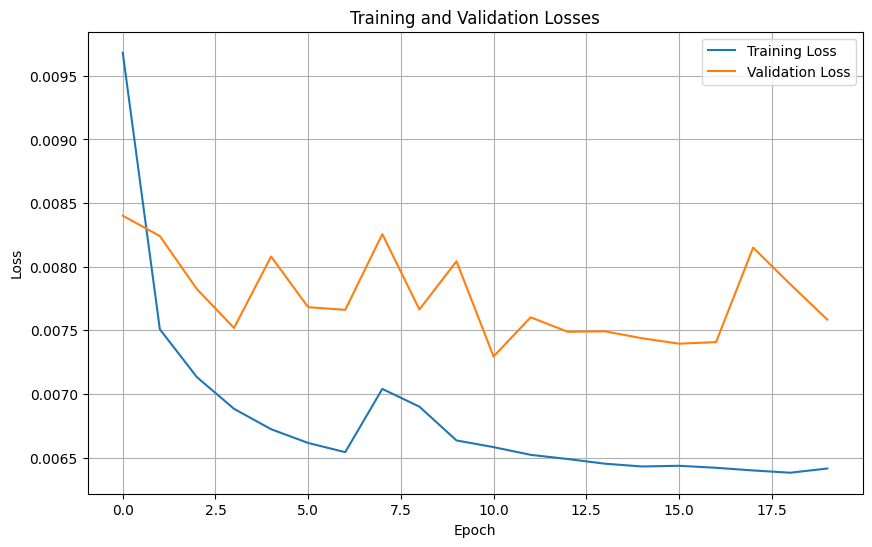

Test loss: 0.009820203296840191
Test R2 score: 0.16356074810028076
Validation loss: 0.00760996900498867
Validation R2 score: 0.2545064091682434


In [128]:
model = NeuralNetwork()
model.fit(train_loader, val_loader, epochs=20, patience=50)
model.plot_losses()

r2_test, mse_test = model.test(test_loader)
r2_val, mse_val = model.test(val_loader)
print(f"Test loss: {mse_test}")
print(f"Test R2 score: {r2_test}")
print(f"Validation loss: {mse_val}")
print(f"Validation R2 score: {r2_val}")

Training: 100%|██████████| 100/100 [30:24<00:00, 18.25s/epoch]


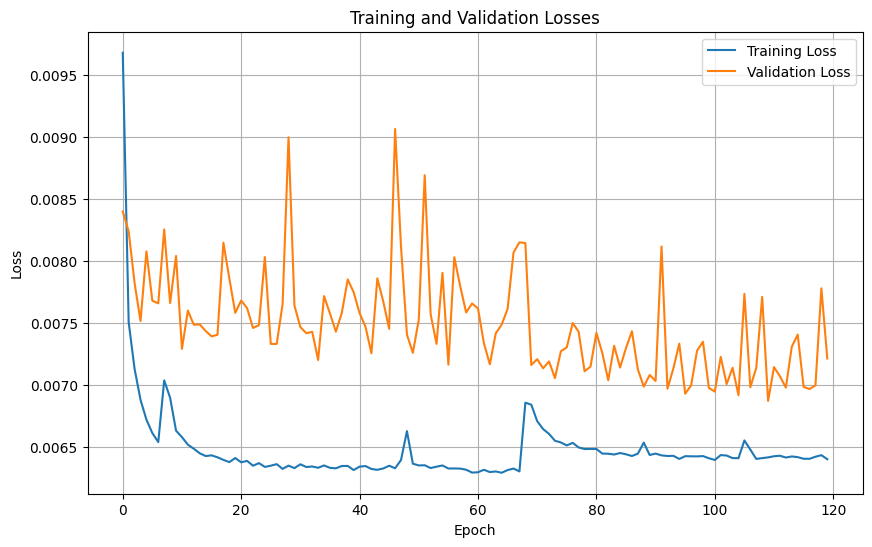

Test loss: 0.011432984843850136
Test R2 score: 0.026191353797912598
Validation loss: 0.007255301345139742
Validation R2 score: 0.28925079107284546


In [129]:
model.fit(train_loader, val_loader, epochs=100, patience=50)
model.plot_losses()

r2_test, mse_test = model.test(test_loader)
r2_val, mse_val = model.test(val_loader)
print(f"Test loss: {mse_test}")
print(f"Test R2 score: {r2_test}")
print(f"Validation loss: {mse_val}")
print(f"Validation R2 score: {r2_val}")

In [130]:
model.save("NN_512_120_0.pkl")

In [131]:
def plot_validation_curve(
    train_loader,
    val_loader,
    param_name="weight_decay",
    param_range=np.logspace(-5, 0, 6),
    epochs=10,
):
    train_scores, val_scores = [], []

    for param in param_range:
        current_model = NeuralNetwork()
        setattr(current_model, param_name, param)
        current_model.fit(train_loader, val_loader, epochs)

        train_scores.append(current_model.losses["train"][-1])
        val_scores.append(current_model.losses["val"][-1])

    plt.figure(figsize=(10, 6))
    if param_name == "weight_decay":
        plt.semilogx(param_range, train_scores, label="Training score", marker="o")
        plt.semilogx(param_range, val_scores, label="Validation score", marker="o")
    else:
        plt.plot(param_range, train_scores, label="Training score", marker="o")
        plt.plot(param_range, val_scores, label="Validation score", marker="o")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.title(f"Validation Curve for {param_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

Training: 100%|██████████| 10/10 [02:58<00:00, 17.81s/epoch]


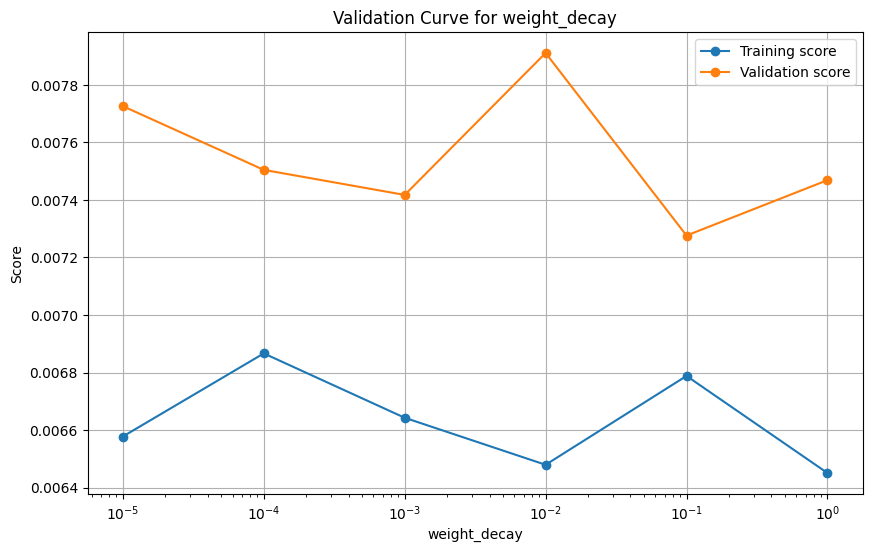

In [132]:
plot_validation_curve(
    train_loader,
    val_loader,
    param_name="weight_decay",
    param_range=np.logspace(-5, 0, 6),
)

Training: 100%|██████████| 10/10 [02:55<00:00, 17.54s/epoch]


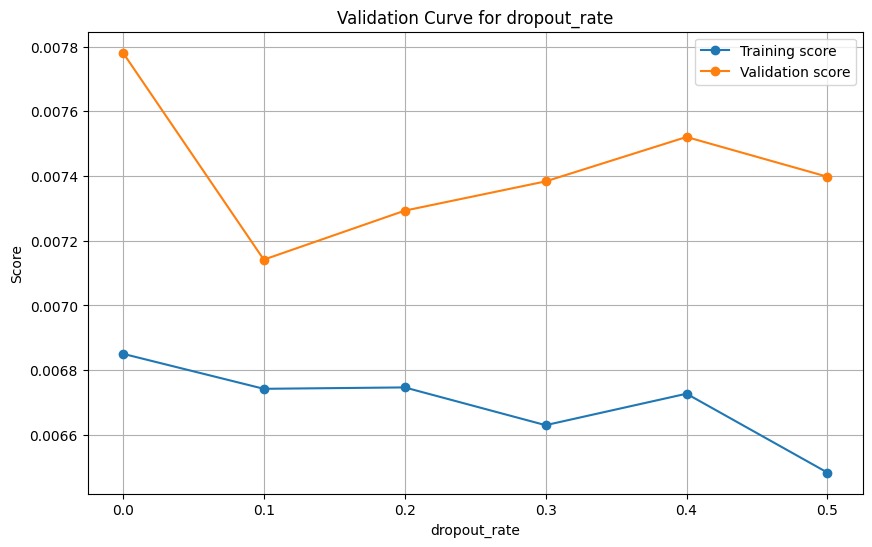

In [133]:
plot_validation_curve(
    train_loader,
    val_loader,
    param_name="dropout_rate",
    param_range=np.linspace(0, 0.5, 6),
)

Training: 100%|██████████| 10/10 [03:06<00:00, 18.65s/epoch]


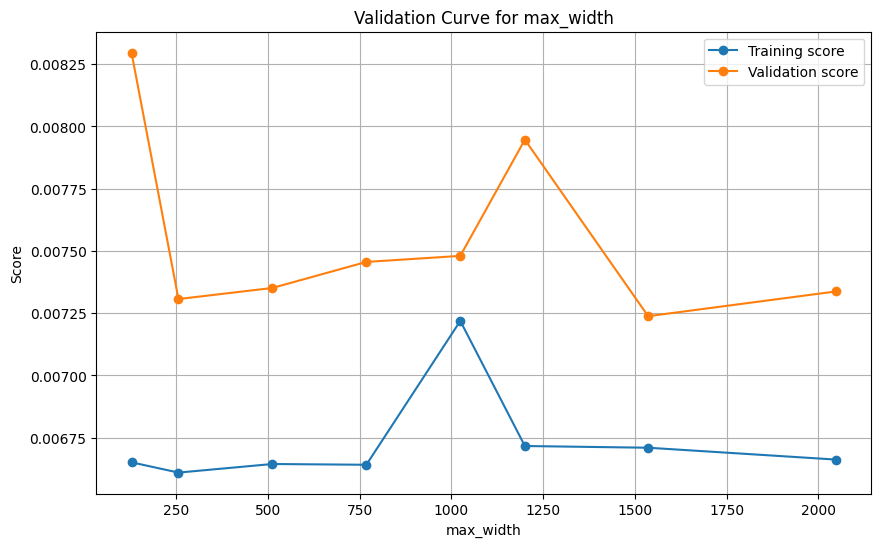

In [134]:
plot_validation_curve(
    train_loader,
    val_loader,
    param_name="max_width",
    param_range=np.array([128, 256, 512, 768, 1024, 1200, 1536, 2048]),
)

Training: 100%|██████████| 10/10 [03:33<00:00, 21.34s/epoch]


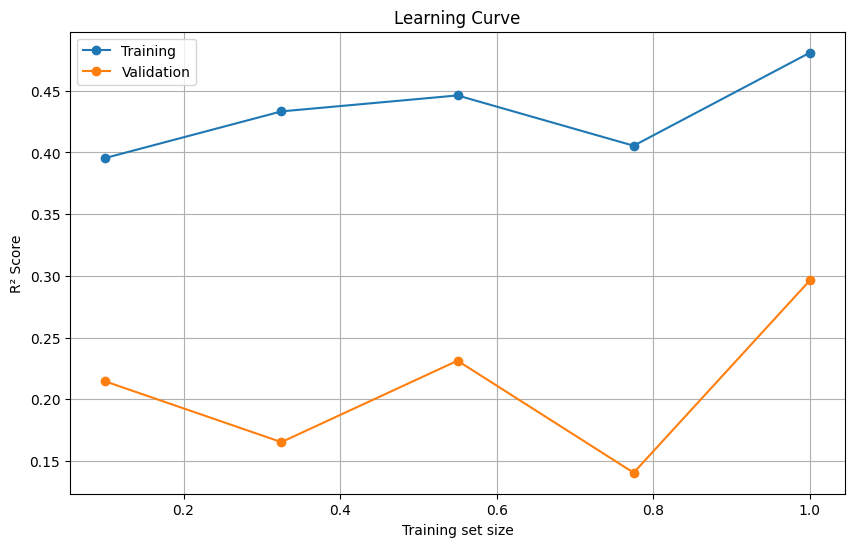

In [135]:
def plot_learning_curve(
    train_loader, val_loader, train_sizes=np.linspace(0.1, 1.0, 5), epochs=10
):
    train_scores, val_scores = [], []

    for size in train_sizes:
        n_samples = int(len(train_loader.dataset) * size)
        indices = torch.randperm(len(train_loader.dataset))[:n_samples]
        subset = torch.utils.data.Subset(train_loader.dataset, indices)
        subset_loader = torch.utils.data.DataLoader(
            subset, batch_size=train_loader.batch_size
        )

        current_model = NeuralNetwork()
        current_model.fit(subset_loader, val_loader, epochs)

        train_preds = current_model.predict(subset_loader)
        val_preds = current_model.predict(val_loader)
        train_r2 = r2_score(
            subset_loader.dataset.dataset.tensors[1][indices].cpu().numpy(),
            train_preds.cpu().numpy(),
        )
        val_r2 = r2_score(
            val_loader.dataset.tensors[1].cpu().numpy(), val_preds.cpu().numpy()
        )

        train_scores.append(train_r2)
        val_scores.append(val_r2)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, label="Training", marker="o")
    plt.plot(train_sizes, val_scores, label="Validation", marker="o")
    plt.xlabel("Training set size")
    plt.ylabel("R² Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_learning_curve(train_loader, val_loader)